Adapted from https://medium.com/swlh/emotion-detection-using-pytorch-4f6fbfd14b2e \
Code: https://jovian.ai/conero007/emotion-detection-resnet

In [1]:
import os
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import torch.utils.data as utils_data

# Constants

In [19]:
data_path = '../dataset/'
model_path = '../trained_models/'

# Preparing the Data

### Load Numpy

In [54]:
with open(data_path + 'ck/graylevels_data_no_contempt.npy', 'rb') as f:
    cropped_dataset = np.load(f)
    cropped_target = np.load(f)

### Load CSV

In [2]:
df = pd.read_csv(data_path + 'fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
pixels = []
for row in df.pixels:
    pixels.append([int(k) for k in row.split(' ')])
cropped_dataset = np.array(pixels)
cropped_dataset = cropped_dataset.reshape(cropped_dataset.shape[0],1, 48, 48)
cropped_target = df.emotion

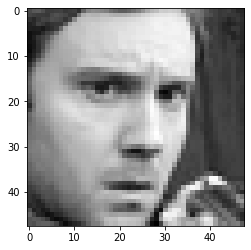

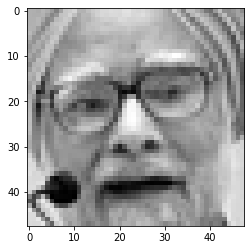

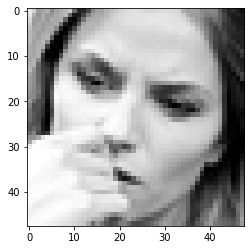

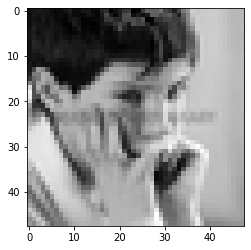

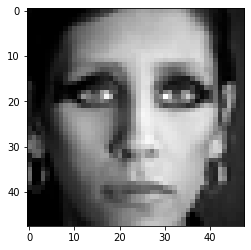

In [4]:
import cv2

# img = cv2.imread(cropped_dataset[0])
for i in range(5):
    plt.imshow(cropped_dataset[i][0], cmap='gray')
    plt.show()

### Get DataLoaders

In [5]:
# moods = ["anger","disgust","fear","happiness","neutral","sadness","surprise"] # CK+
moods = ["anger","disgust","fear","happiness","sadness","surprise","neutral"] # FER
mood_map = { moods[k]:k for k in range(len(moods)) } # mood : index
mood_map.update({ k:moods[k] for k in range(len(moods)) }) # index : mood

In [6]:
def get_dataloaders(data, label, split_ratio=0.8):
    dataset_size = data.shape[0]
    train_size = int(split_ratio * dataset_size)
    test_size = dataset_size - train_size

    dataset = utils_data.TensorDataset(torch.Tensor(data), torch.LongTensor(label))
    train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
    batch_size = 8
    train_loader = utils_data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = utils_data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
    print('Data is ready!')
    
    return train_loader, test_loader

In [7]:
Image = cropped_dataset/255.0
# Label = np.array([float(mood_map[k]) for k in cropped_target]) # CK+
Label = cropped_target # FER
print(Image.shape, Label.shape)
px_train_loader, px_test_loader = get_dataloaders(Image, Label)

(35887, 1, 48, 48) (35887,)
Data is ready!


# Using a GPU

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(px_train_loader, device)
valid_dl = DeviceDataLoader(px_test_loader, device)

# Training Steps Creation

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result, total, print_epoch):
        if (not epoch % print_epoch) or epoch==total-1:
            print('epoch=%d  ' % epoch + (' ' if epoch<10 else ''), end="")
            print('last_lr={:.5f}   train loss={:.4f}   test loss={:.4f}   train accuracy={:.4f}   test accuracy={:.4f}'.format(
                result['lrs'][-1], result['train_loss'], result['val_loss'], result['train_acc'], result['val_acc']))

# Model Creation

In [12]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

# Training the Model

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(model, train_loader, val_loader, 
                  epochs, max_lr,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam,
                  best_acc=0, print_epoch=1, name="CNN"):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses, train_accs = [], []
        lrs = []
        for batch in train_loader:            
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result, total=epochs, print_epoch=print_epoch)
        history.append(result)
        
        # Save model
        if result['val_acc'] > best_acc:
            best_state = model.state_dict()
        
    return history, best_state

In [21]:
# Create new model
model = to_device(ResNet(1, len(moods)), device)
history = [evaluate(model, valid_dl)]

In [ ]:
# Load new model
state = torch.load(model_path + 'CNN_fer.pth')
model.load_state_dict(state['state_dict'])
history = state['history']

In [24]:
%%time
history_one_cycle, best_state = fit_one_cycle(model, train_dl, valid_dl, 
                                              epochs=24, max_lr=0.008, 
                                              grad_clip=0.1, weight_decay=1e-4, opt_func=torch.optim.Adam,
                                              best_acc=history[-1]['val_acc'], print_epoch=1, name="CNN_fer")
history = ([] if len(history)==1 else history) + history_one_cycle

epoch=0   last_lr=0.00055   train loss=1.7119   test loss=1.5656   train accuracy=0.3670   test accuracy=0.3790
epoch=1   last_lr=0.00122   train loss=1.7126   test loss=1.5987   train accuracy=0.3716   test accuracy=0.3353
epoch=2   last_lr=0.00224   train loss=1.7162   test loss=1.6942   train accuracy=0.3557   test accuracy=0.3415
epoch=3   last_lr=0.00349   train loss=1.7376   test loss=2.3133   train accuracy=0.3543   test accuracy=0.2227
epoch=4   last_lr=0.00483   train loss=1.7534   test loss=2.5438   train accuracy=0.3635   test accuracy=0.2801
epoch=5   last_lr=0.00608   train loss=1.8214   test loss=2.2850   train accuracy=0.3597   test accuracy=0.3337
epoch=6   last_lr=0.00710   train loss=1.9581   test loss=3.0353   train accuracy=0.3478   test accuracy=0.2153
epoch=7   last_lr=0.00777   train loss=2.1672   test loss=2.3094   train accuracy=0.3443   test accuracy=0.3351
epoch=8   last_lr=0.00800   train loss=2.3813   test loss=1.9397   train accuracy=0.3423   test accuracy

# Plotting Performance Graphs of the Model

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

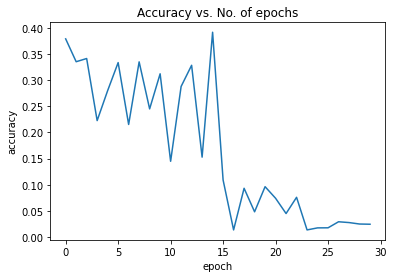

In [27]:
plot_accuracies(history)

In [28]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

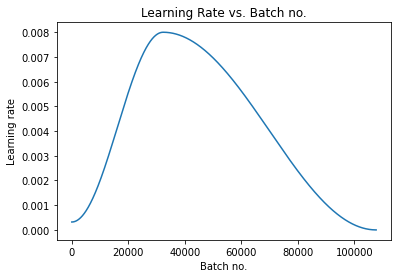

In [29]:
plot_lrs(history)

## Saving the Model


In [20]:
# torch.save(model.state_dict(), './trained_models/CNNModel.pth')
state = {
    'history': history,
    'state_dict': best_state
}
torch.save(state, model_path + 'CNN_fer.pth')

# Testing the Model

In [21]:
import random
import math
import dlib
import cv2
import imutils
from imutils import face_utils

In [22]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [23]:
# get all image filenames
image_filenames = []
for root, dirs, files in os.walk(data_path):
    dirc = os.path.basename(root)
    if dirc != "contempt":
        for file in files:
            image_filenames += [data_path + dirc + '/' + file]        

In [24]:
# load models
cnn_model = to_device(ResNet(1, len(moods)), device)
cnn_model.load_state_dict(torch.load('./trained_models/CNNModel.pth'))
cnn_model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

A: anger, P(CNN): anger


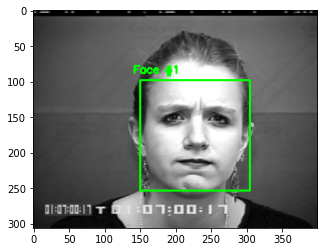

A: surprise, P(CNN): surprise


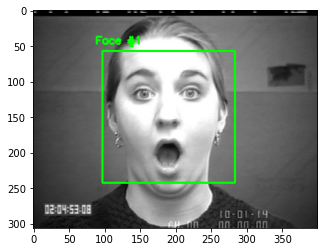

A: neutral, P(CNN): neutral


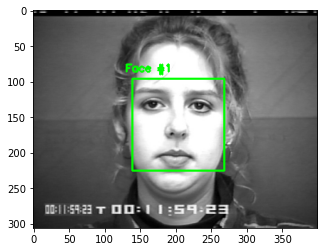

A: neutral, P(CNN): neutral


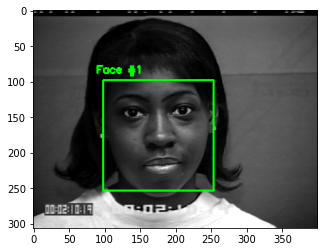

A: neutral, P(CNN): neutral


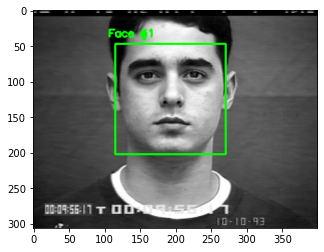

A: neutral, P(CNN): neutral


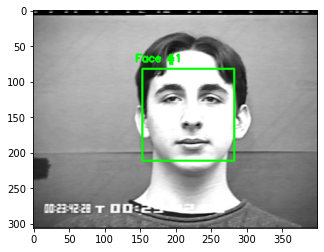

A: surprise, P(CNN): surprise


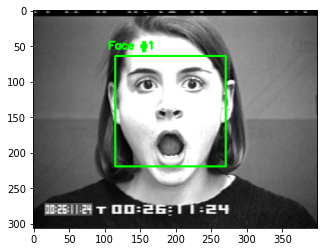

A: neutral, P(CNN): neutral


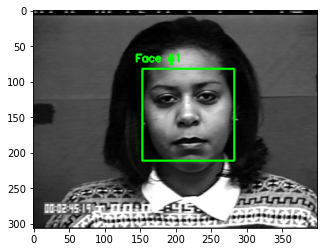

A: fear, P(CNN): fear


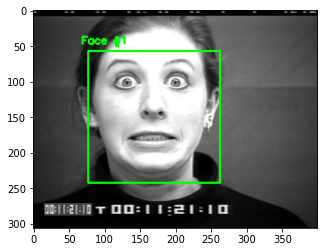

A: fear, P(CNN): fear


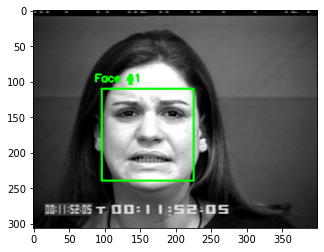

In [25]:
rand_images = random.sample(image_filenames, 10) # get random images  

for path in rand_images:   
    vectors, coords = [], []

    image = cv2.imread(path)
    image = imutils.resize(image, width=400)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    rects = detector(gray, 1)         

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)          
            
        (x,y,w,h) = face_utils.rect_to_bb(rect) # convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x,y,w,h)]
        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2) # draw the face bounding box
        cv2.putText(image, "Face #{}".format(i+1), (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2) # show face number
    
    ## graylevel input
    dim = 50
    cnn_input = image[y:y+h, x:x+w] # crop to face
    cnn_input = cv2.cvtColor(cnn_input, cv2.COLOR_RGB2GRAY) # convert to grayscale
    cnn_input = cv2.equalizeHist(cnn_input) # equalize histogram
    cnn_input = imutils.resize(cnn_input, width=int(dim*1.05)) # buffer of 5 pixels for cropping to 100x100
    cnn_input = cnn_input[:dim,:dim]
    cnn_input = cnn_input.reshape(1,1,dim,dim)/255.0 # shape=(1,1,dim,dim)
    
    # prediction
    with torch.no_grad():
        cnn_pred_tensor = cnn_model(torch.Tensor(cnn_input).cuda())
        cnn_pred = cnn_pred_tensor.argmax().cpu().numpy().item()        
    cnn_pred_label = mood_map[cnn_pred]
#     cv2.putText(image, '%s' % pred_label, (x,y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    
    true_label = path.split('/')[2]
    print("A: %s, P(CNN): %s" % (true_label, cnn_pred_label))
    plt.imshow(image) # adapted for jupyter
    plt.show()